# Betrayal Detection in Diplomacy

Diplomacy is a strategic board game with social deception elements. The game consists of phases where players may negotiate and betray each other. We will attempt to predict whether betrayal occurs based off of the messages that players send to each other.

In [518]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix


import re

# Basic Preprocessing

First we preprocess the dataset into a dataframe that is easier to interpret for exploration/training.

In Diplomacy, each game is divided into multiple phases called seasons. Within each season, players can communicate with each other to coordinate attacks. Every entry in the original dataset consists of a particular interaction between two players in a game, containing statistical data regarding their messages spread across all seasons.

Therefore, in our preprocessed dataframe we will aggregate all message data per each season of the game, as we are only concerned about whether or not there was a betrayal in the interaction for the game as a whole.

In [519]:
df = pd.read_json('diplomacy_data.json')
# entries represent an interaction between two players in a particular game, spread across
# all of the games seasons

data = [] # 2d array to hold processed data

# we create a new processed pandas dataframe based off of the old one
'''
Our processed data will contain the following structure:

ID | Betrayal (T/F) | victim # msgs | betrayer # msgs |
victim # sentences | betrayer # sentences |
victim # words | betrayer # words | victim avg words per msg | betrayer avg words per msg | 
victim # requests | betrayer # requests | victim avg politeness | betrayer avg politeness | 
victim neg sentiment proportion | victim neu sentiment proportion |
victim pos sentiment proportion| betrayer neg sentiment proportion  | 
betrayer neu sentiment proportion | betrayer pos sentiment proportion | 

Note that if no betrayal occurs, the 'betrayer' label indicates the other person in the interaction,
chosen arbitrarily.


'''

betrayals = df['betrayal']
game_session_seasons = df['seasons']

# splits countries
countries =[list(i) for i in df['people'].to_numpy()]

# finds all unique countries and how many there are
countries_unique = np.concatenate(countries, axis=0 )
countries_unique = list(np.unique(countries_unique))
num_of_countries = len(countries_unique)


# create our new processed df

season2 = df['seasons'][7]

for season in season2:
    msgs = season['messages']['betrayer']
    for msg in msgs:
        print("sentences: ", msg['n_sentences'])
        print(msg['sentiment'])

for i, seasons in enumerate(game_session_seasons):

    # print("new entry")
    
    entry = [] # represents a row of our new pandas dataframe

    # if this interaction is a betrayal
    betrayal = betrayals[i]
    entry.append(betrayal)

    # initialize all data that needs to be kept track of 
    v_msgs, b_msgs = 0, 0
    v_sentences, b_sentences = 0, 0
    v_words, b_words = 0, 0
    v_words_per_msg, b_words_per_msg = 0, 0
    v_requests, b_requests = 0, 0
    v_avg_polite, b_avg_polite = 0, 0
    v_neg_perc, b_neg_perc = 0, 0
    v_net_perc, b_net_perc = 0, 0
    v_pos_perc, b_pos_perc = 0, 0
    
    # stores the first country into victim_country and 2nd into betrayer_country
    # it finds the index of the country in countries_unique and divides it over num_of_countries-1
    # this normalizes the countries values between 0 and 1
    v_country = countries_unique.index(countries[i][0])/(num_of_countries - 1)
    b_country = countries_unique.index(countries[i][1])/(num_of_countries - 1)

    for season in seasons:
        # print(season)

        v_msg_list = season['messages']['victim']
        b_msg_list = season['messages']['betrayer']

        if len(v_msg_list) > 0:
            v_msgs = len(v_msg_list)

            # track victim message stats
            for msg in v_msg_list:
                v_sentences += msg['n_sentences']
                v_words += msg['n_words']
                v_requests += msg['n_requests']
                v_avg_polite += msg['politeness']
                v_neg_perc += msg['sentiment']['negative']
                v_net_perc += msg['sentiment']['neutral']
                v_pos_perc += msg['sentiment']['positive']
                
                
        if len(b_msg_list) > 0:
            b_msgs += len(b_msg_list)

            # track betrayer message stats
            for msg in b_msg_list:
                b_sentences += msg['n_sentences']
                b_words += msg['n_words']
                b_requests += msg['n_requests']
                b_avg_polite += msg['politeness']
                b_neg_perc += msg['sentiment']['negative']
                b_net_perc += msg['sentiment']['neutral']
                b_pos_perc += msg['sentiment']['positive']
                
    entry.append(v_msgs) # total amount of victim msgs for all seasons in this entry
    entry.append(b_msgs)
    
    entry.append(v_sentences)
    entry.append(b_sentences)
    
    entry.append(v_words)
    entry.append(b_words)
    
    if v_msgs != 0:
        v_words_per_msg = v_words/v_msgs
    
    if b_msgs != 0:
        b_words_per_msg = b_words/b_msgs
    
    # remove entries with no conversation
    if v_msgs == 0 and b_msgs == 0:
        continue
    
    entry.append(v_words_per_msg)
    entry.append(b_words_per_msg)
    
    entry.append(v_requests)
    entry.append(b_requests)
    
    if v_msgs != 0:
        v_avg_polite = v_avg_polite/v_msgs
        
    if b_msgs != 0:
        b_avg_polite = b_avg_polite/b_msgs
        
    entry.append(v_avg_polite)
    entry.append(b_avg_polite)
        
    if v_sentences != 0:
        v_neg_perc = v_neg_perc/v_sentences
        v_net_perc = v_net_perc/v_sentences
        v_pos_perc = v_pos_perc/v_sentences
        
    entry.append(v_neg_perc)
    entry.append(v_net_perc)
    entry.append(v_pos_perc)
    
    if b_sentences != 0:
        b_neg_perc = b_neg_perc/b_sentences
        b_net_perc = b_net_perc/b_sentences
        b_pos_perc = b_pos_perc/b_sentences
        
    entry.append(b_neg_perc)
    entry.append(b_net_perc)
    entry.append(b_pos_perc)
    entry.append(v_country)
    entry.append(b_country)
    
    data.append(entry)

print(len(data))

# create a new dataframe of our processed data
columns = ['betrayal', 'victim_msgs', 'betrayer_msgs', 'victim_sentences', 'betrayer_sentences', 
           'victim_words', 'betrayer_words', 'victim_words_per_msg', 'betrayer_words_per_msg',
          'victim_reqs', 'betrayer_reqs', 'victim_avg_polite', 'betrayer_avg_polite',
          'victim_neg_perc', 'victim_neu_perc', 'victim_pos_perc', 'betrayer_neg_perc',
          'betrayer_neu_perc', 'betrayer_pos_perc', 'victim_country', 'betrayer_country']

new_df = pd.DataFrame(data, columns=columns)
print(len(new_df))
# print(new_df)
new_df.to_csv('447processed.csv')

sentences:  2
{'positive': 1, 'neutral': 1, 'negative': 0}
sentences:  2
{'positive': 0, 'neutral': 2, 'negative': 0}
410
410


<h1> Data Exploration </h1>

As mentioned previously, Diplomacy is a strategic board game primarily based around negotiation. Players control one of the seven major powers from the early 20th century, such as Austria-Hungary, Germany, France, Great Britain, etc. The nature of negotation draws the natural conclusion similarly seen in nature, symbiosis. Players may want to have a mutualistic relationship, where they will both benefit, or, they may wish to take at someone else's expense. Hence, deception is also a major component of Diplomacy. You could promise another player your support in a battle, and then on the next movement opportunity, decide to attack them instead, costing them valuable resources, or even the game. This leads to a very complicated and delicate balance which we attempt to describe by using prediction algorithms with data taken from games played.

In [520]:
print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   betrayal                410 non-null    bool   
 1   victim_msgs             410 non-null    int64  
 2   betrayer_msgs           410 non-null    int64  
 3   victim_sentences        410 non-null    int64  
 4   betrayer_sentences      410 non-null    int64  
 5   victim_words            410 non-null    int64  
 6   betrayer_words          410 non-null    int64  
 7   victim_words_per_msg    410 non-null    float64
 8   betrayer_words_per_msg  410 non-null    float64
 9   victim_reqs             410 non-null    int64  
 10  betrayer_reqs           410 non-null    int64  
 11  victim_avg_polite       410 non-null    float64
 12  betrayer_avg_polite     410 non-null    float64
 13  victim_neg_perc         410 non-null    float64
 14  victim_neu_perc         410 non-null    fl

In [521]:
X=new_df.drop(columns=["betrayal"],axis=1)
y=new_df["betrayal"]
display(X)
display(y)

,victim_msgs,betrayer_msgs,victim_sentences,betrayer_sentences,victim_words,betrayer_words,victim_words_per_msg,betrayer_words_per_msg,victim_reqs,betrayer_reqs,victim_avg_polite,betrayer_avg_polite,victim_neg_perc,victim_neu_perc,victim_pos_perc,betrayer_neg_perc,betrayer_neu_perc,betrayer_pos_perc,victim_country,betrayer_country
0,2,30,112,108,1451,2104,725.500000,70.133333,39,83,6.700666,0.730269,0.544643,0.276786,0.178571,0.472222,0.296296,0.231481,0.000000,1.000000
1,1,8,12,11,112,101,112.000000,12.625000,4,6,2.469204,0.464686,0.416667,0.500000,0.083333,0.636364,0.363636,0.000000,0.166667,0.500000
2,1,11,21,27,368,687,368.000000,62.454545,9,12,4.132162,0.542905,0.571429,0.333333,0.095238,0.666667,0.222222,0.111111,0.000000,0.833333
3,3,8,79,42,1552,802,517.333333,100.250000,54,28,3.019870,0.600306,0.569620,0.202532,0.227848,0.595238,0.238095,0.166667,0.000000,0.833333
4,1,9,21,29,234,344,234.000000,38.222222,18,13,3.326234,0.663111,0.428571,0.333333,0.238095,0.344828,0.413793,0.241379,0.666667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,1,9,12,69,154,1242,154.000000,138.000000,4,37,2.809516,0.832442,0.416667,0.333333,0.250000,0.565217,0.289855,0.144928,0.833333,1.000000
406,3,13,135,127,1994,2385,664.666667,183.461538,47,58,3.224819,0.698891,0.548148,0.281481,0.170370,0.425197,0.275591,0.299213,0.000000,0.833333
407,1,9,48,61,607,923,607.000000,102.555556,25,37,9.629614,0.646064,0.541667,0.312500,0.145833,0.442623,0.377049,0.180328,0.833333,0.166667
408,3,21,184,173,2308,3016,769.333333,143.619048,71,72,5.417420,0.535524,0.445652,0.418478,0.135870,0.578035,0.260116,0.161850,0.500000,0.166667


0       True
1      False
2      False
3      False
4      False
       ...  
405    False
406     True
407     True
408     True
409     True
Name: betrayal, Length: 410, dtype: bool

In [522]:
X.describe()

,victim_msgs,betrayer_msgs,victim_sentences,betrayer_sentences,victim_words,betrayer_words,victim_words_per_msg,betrayer_words_per_msg,victim_reqs,betrayer_reqs,victim_avg_polite,betrayer_avg_polite,victim_neg_perc,victim_neu_perc,victim_pos_perc,betrayer_neg_perc,betrayer_neu_perc,betrayer_pos_perc,victim_country,betrayer_country
count,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000
mean,1.778049,12.231707,70.541463,76.319512,1056.229268,1136.390244,577.835385,70.699029,34.173171,37.043902,4.433363,0.633118,0.475374,0.330035,0.150689,0.467768,0.341860,0.165982,0.410976,0.613008
std,1.411447,14.556440,107.303739,125.472029,1817.679823,2089.910238,833.437302,48.254030,53.879897,63.615848,4.146381,0.157176,0.185976,0.162794,0.106027,0.172909,0.166082,0.102112,0.329029,0.301168
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.000000,12.000000,14.000000,158.750000,163.250000,115.250000,35.500000,5.000000,6.000000,1.705924,0.566223,0.401010,0.250000,0.095326,0.400000,0.257033,0.109596,0.166667,0.333333
50%,1.000000,9.000000,37.000000,41.000000,506.500000,532.500000,320.000000,62.333333,18.000000,19.000000,3.147634,0.656107,0.498555,0.322581,0.151026,0.486833,0.333333,0.166667,0.333333,0.666667
75%,2.000000,15.000000,79.750000,87.750000,1192.000000,1219.250000,678.300000,90.587798,38.000000,41.750000,5.770966,0.730070,0.576010,0.415441,0.200000,0.555556,0.411706,0.220909,0.666667,0.833333
max,13.000000,125.000000,936.000000,1159.000000,17181.000000,23293.000000,7417.000000,344.976744,416.000000,596.000000,24.406230,0.940893,1.000000,1.000000,1.000000,1.000000,1.000000,0.600000,1.000000,1.000000


In [523]:
y.describe()

count       410
unique        2
top       False
freq        206
Name: betrayal, dtype: object

<h2> Betrayal Identification </h2>

Unfortunately, we can't really see any trends yet, as if the "Betrayal" column is false, the betrayal data isn't very relevant. Let's take out the rows with Betrayal as "False" and see the new described data.

In [524]:
drop_df = new_df[new_df.betrayal == True]
display(drop_df)

,betrayal,victim_msgs,betrayer_msgs,victim_sentences,betrayer_sentences,victim_words,betrayer_words,victim_words_per_msg,betrayer_words_per_msg,victim_reqs,...,victim_avg_polite,betrayer_avg_polite,victim_neg_perc,victim_neu_perc,victim_pos_perc,betrayer_neg_perc,betrayer_neu_perc,betrayer_pos_perc,victim_country,betrayer_country
0,True,2,30,112,108,1451,2104,725.500000,70.133333,39,...,6.700666,0.730269,0.544643,0.276786,0.178571,0.472222,0.296296,0.231481,0.000000,1.000000
5,True,1,20,108,121,1489,1697,1489.000000,84.850000,53,...,10.965025,0.683075,0.462963,0.333333,0.203704,0.446281,0.272727,0.280992,0.000000,0.500000
8,True,1,9,8,25,47,236,47.000000,26.222222,3,...,2.057574,0.586314,0.125000,0.500000,0.375000,0.400000,0.360000,0.240000,0.500000,1.000000
9,True,1,4,11,12,133,121,133.000000,30.250000,10,...,3.315499,0.598440,0.272727,0.727273,0.000000,0.500000,0.250000,0.250000,0.833333,0.000000
10,True,2,5,26,17,286,209,143.000000,41.800000,8,...,1.441538,0.564996,0.423077,0.423077,0.153846,0.529412,0.352941,0.117647,0.833333,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,True,3,9,59,65,800,964,266.666667,107.111111,26,...,2.245177,0.779825,0.389831,0.406780,0.203390,0.507692,0.323077,0.169231,0.166667,0.500000
406,True,3,13,135,127,1994,2385,664.666667,183.461538,47,...,3.224819,0.698891,0.548148,0.281481,0.170370,0.425197,0.275591,0.299213,0.000000,0.833333
407,True,1,9,48,61,607,923,607.000000,102.555556,25,...,9.629614,0.646064,0.541667,0.312500,0.145833,0.442623,0.377049,0.180328,0.833333,0.166667
408,True,3,21,184,173,2308,3016,769.333333,143.619048,71,...,5.417420,0.535524,0.445652,0.418478,0.135870,0.578035,0.260116,0.161850,0.500000,0.166667


In [525]:
drop_df.describe()

,victim_msgs,betrayer_msgs,victim_sentences,betrayer_sentences,victim_words,betrayer_words,victim_words_per_msg,betrayer_words_per_msg,victim_reqs,betrayer_reqs,victim_avg_polite,betrayer_avg_polite,victim_neg_perc,victim_neu_perc,victim_pos_perc,betrayer_neg_perc,betrayer_neu_perc,betrayer_pos_perc,victim_country,betrayer_country
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,1.867647,12.686275,73.901961,81.161765,1113.078431,1171.063725,594.989793,72.769813,35.156863,39.132353,4.344829,0.643633,0.469130,0.339318,0.157238,0.466370,0.332034,0.181988,0.543301,0.516340
std,1.334326,14.514121,115.529879,122.273852,2033.683041,1867.616381,943.772528,47.466178,55.602609,61.930178,4.260501,0.151691,0.189309,0.164881,0.104043,0.168043,0.157086,0.102703,0.334814,0.326288
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,5.000000,11.000000,17.000000,155.000000,179.750000,100.750000,36.587500,5.000000,8.000000,1.692463,0.583333,0.400000,0.262024,0.101751,0.400000,0.256343,0.126489,0.333333,0.333333
50%,1.000000,9.000000,38.500000,46.500000,548.000000,581.500000,324.250000,64.944444,19.000000,21.000000,2.904215,0.664437,0.484360,0.332184,0.153846,0.483046,0.326136,0.176671,0.500000,0.500000
75%,2.000000,16.000000,86.250000,100.000000,1187.750000,1370.000000,665.500000,94.052083,39.000000,47.000000,5.760769,0.735732,0.561543,0.418697,0.204740,0.543219,0.381952,0.231787,0.833333,0.833333
max,8.000000,125.000000,936.000000,1123.000000,17181.000000,14834.000000,7417.000000,344.976744,416.000000,596.000000,24.406230,0.929327,1.000000,1.000000,0.666667,1.000000,1.000000,0.600000,1.000000,1.000000


We can see some subtle differences between a traitor and a victim. Betrayers send more messages, with more sentences overall.

Let's take a look at these graphically.

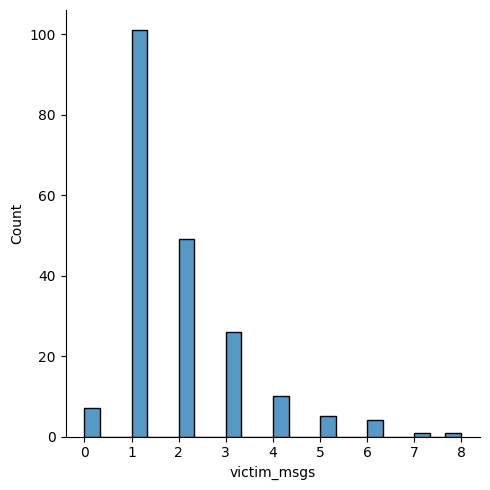

In [526]:
z = sns.displot(drop_df['victim_msgs']);
plt.show(z)

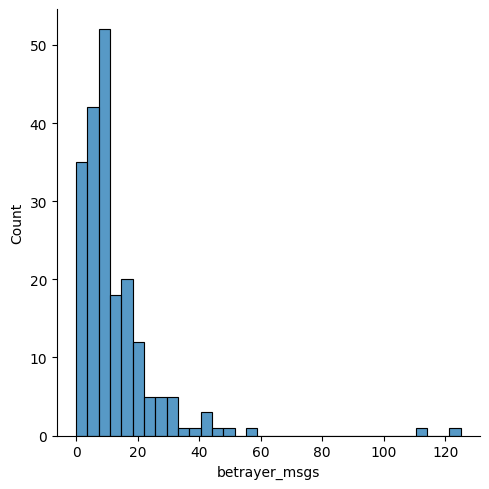

In [527]:
z = sns.displot(drop_df['betrayer_msgs']);
plt.show(z)

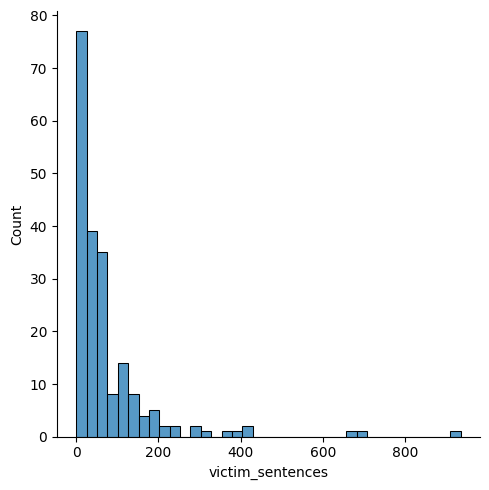

In [528]:
z = sns.displot(drop_df['victim_sentences']);
plt.show(z)

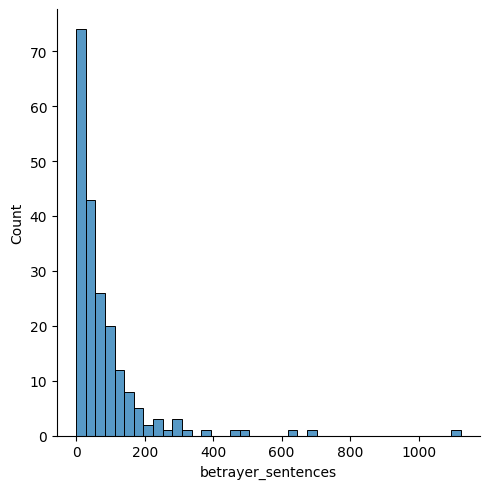

In [529]:
z = sns.displot(drop_df['betrayer_sentences']);
plt.show(z)

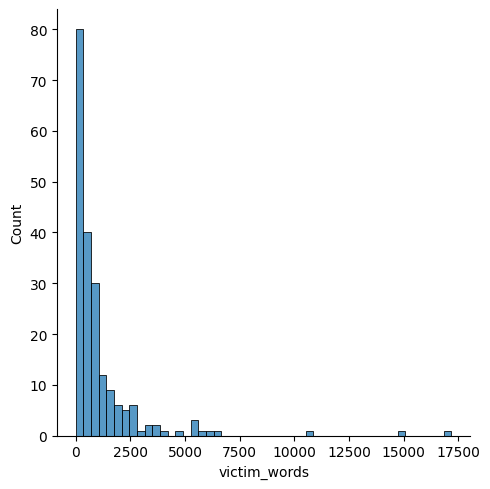

In [530]:
z = sns.displot(drop_df['victim_words']);
plt.show(z)

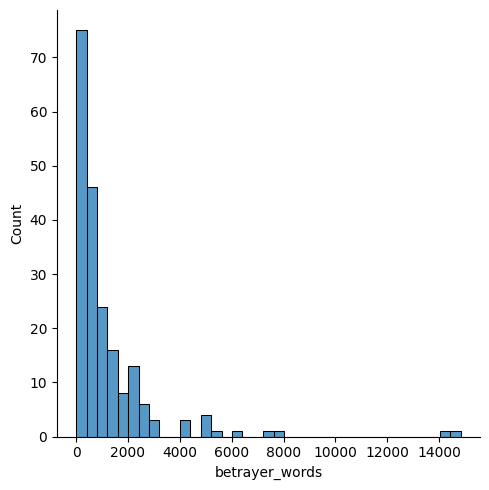

In [531]:
z = sns.displot(drop_df['betrayer_words']);
plt.show(z)

Graphically, it is not very easy to see very much difference.

In [532]:
drop_df.describe()

,victim_msgs,betrayer_msgs,victim_sentences,betrayer_sentences,victim_words,betrayer_words,victim_words_per_msg,betrayer_words_per_msg,victim_reqs,betrayer_reqs,victim_avg_polite,betrayer_avg_polite,victim_neg_perc,victim_neu_perc,victim_pos_perc,betrayer_neg_perc,betrayer_neu_perc,betrayer_pos_perc,victim_country,betrayer_country
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,1.867647,12.686275,73.901961,81.161765,1113.078431,1171.063725,594.989793,72.769813,35.156863,39.132353,4.344829,0.643633,0.469130,0.339318,0.157238,0.466370,0.332034,0.181988,0.543301,0.516340
std,1.334326,14.514121,115.529879,122.273852,2033.683041,1867.616381,943.772528,47.466178,55.602609,61.930178,4.260501,0.151691,0.189309,0.164881,0.104043,0.168043,0.157086,0.102703,0.334814,0.326288
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,5.000000,11.000000,17.000000,155.000000,179.750000,100.750000,36.587500,5.000000,8.000000,1.692463,0.583333,0.400000,0.262024,0.101751,0.400000,0.256343,0.126489,0.333333,0.333333
50%,1.000000,9.000000,38.500000,46.500000,548.000000,581.500000,324.250000,64.944444,19.000000,21.000000,2.904215,0.664437,0.484360,0.332184,0.153846,0.483046,0.326136,0.176671,0.500000,0.500000
75%,2.000000,16.000000,86.250000,100.000000,1187.750000,1370.000000,665.500000,94.052083,39.000000,47.000000,5.760769,0.735732,0.561543,0.418697,0.204740,0.543219,0.381952,0.231787,0.833333,0.833333
max,8.000000,125.000000,936.000000,1123.000000,17181.000000,14834.000000,7417.000000,344.976744,416.000000,596.000000,24.406230,0.929327,1.000000,1.000000,0.666667,1.000000,1.000000,0.600000,1.000000,1.000000


Taking a look at our data again, let's take a look at the number of requests, the average "politeness" they had towards one another, and the proportion of negatively, neutrally, or positively perceived messages. Betrayers make more requests on average, and are slightly more polite. What is also interesting is the very large proportion of negatively perceived messages on both sides. Seldomly are their messages interpreted as positive, but the victim on average perceives the betrayers messages as positive more.

Lets look at these graphically.

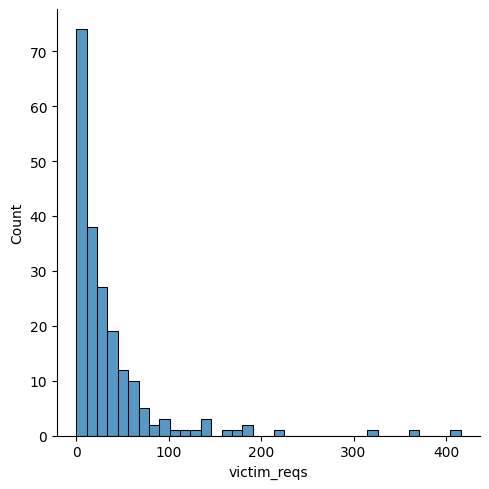

In [533]:
z = sns.displot(drop_df['victim_reqs']);
plt.show(z)

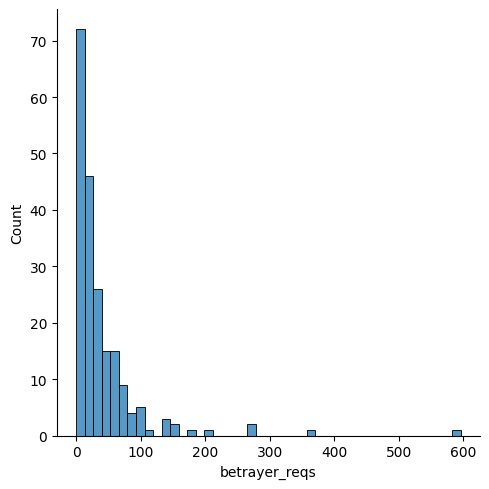

In [534]:
z = sns.displot(drop_df['betrayer_reqs']);
plt.show(z)

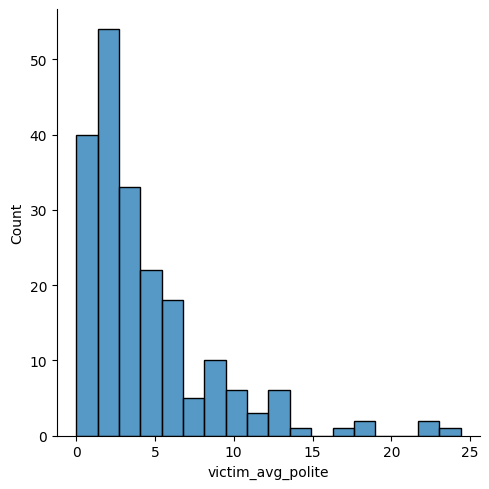

In [535]:

z = sns.displot(drop_df['victim_avg_polite']);
plt.show(z)

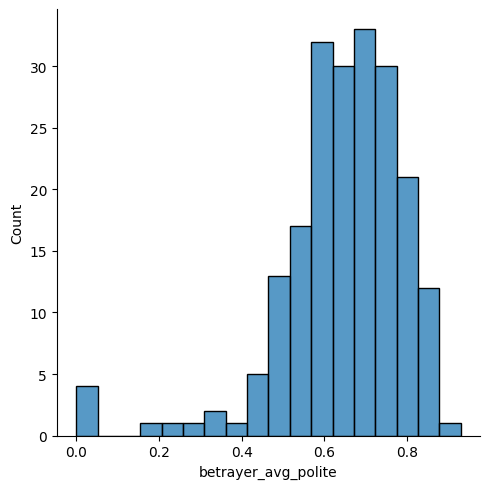

In [536]:

z = sns.displot(drop_df['betrayer_avg_polite']);
plt.show(z)

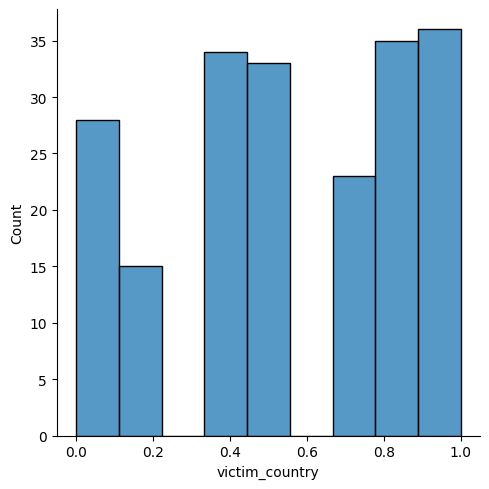

In [537]:
z = sns.displot(drop_df['victim_country']);
plt.show(z)

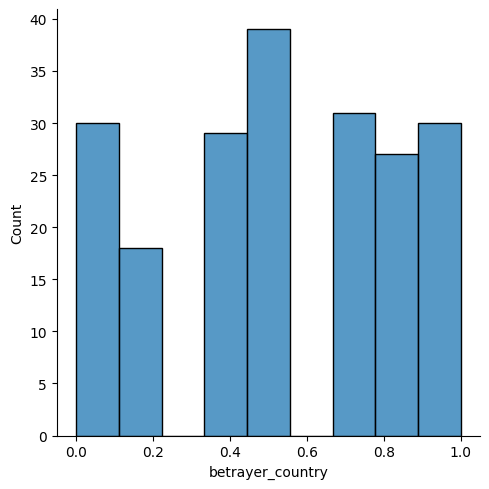

In [538]:
z = sns.displot(drop_df['betrayer_country']);
plt.show(z)

<h2> Relationship between Victim and Allies or Betrayers </h2>

Here, let's briefly discuss and explore how the dynamic between a victim and ally/traitor affects their communication or gameplay.

First, let's get the dataframe with no betrayals.

In [539]:
false_df = new_df[new_df.betrayal == False]
display(false_df)

,betrayal,victim_msgs,betrayer_msgs,victim_sentences,betrayer_sentences,victim_words,betrayer_words,victim_words_per_msg,betrayer_words_per_msg,victim_reqs,...,victim_avg_polite,betrayer_avg_polite,victim_neg_perc,victim_neu_perc,victim_pos_perc,betrayer_neg_perc,betrayer_neu_perc,betrayer_pos_perc,victim_country,betrayer_country
1,False,1,8,12,11,112,101,112.000000,12.625000,4,...,2.469204,0.464686,0.416667,0.500000,0.083333,0.636364,0.363636,0.000000,0.166667,0.500000
2,False,1,11,21,27,368,687,368.000000,62.454545,9,...,4.132162,0.542905,0.571429,0.333333,0.095238,0.666667,0.222222,0.111111,0.000000,0.833333
3,False,3,8,79,42,1552,802,517.333333,100.250000,54,...,3.019870,0.600306,0.569620,0.202532,0.227848,0.595238,0.238095,0.166667,0.000000,0.833333
4,False,1,9,21,29,234,344,234.000000,38.222222,18,...,3.326234,0.663111,0.428571,0.333333,0.238095,0.344828,0.413793,0.241379,0.666667,1.000000
6,False,1,4,13,17,170,156,170.000000,39.000000,5,...,1.699153,0.677558,0.615385,0.384615,0.000000,0.235294,0.647059,0.117647,0.666667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,False,3,14,146,62,3402,912,1134.000000,65.142857,84,...,3.272780,0.599432,0.630137,0.287671,0.082192,0.564516,0.193548,0.241935,0.166667,0.833333
400,False,1,16,44,44,638,575,638.000000,35.937500,26,...,5.856704,0.438122,0.613636,0.295455,0.090909,0.500000,0.272727,0.227273,0.000000,0.666667
402,False,1,9,83,37,851,571,851.000000,63.444444,39,...,9.822757,0.688892,0.373494,0.542169,0.084337,0.513514,0.378378,0.108108,0.000000,0.666667
404,False,1,6,24,8,332,127,332.000000,21.166667,10,...,4.121982,0.630192,0.583333,0.291667,0.125000,0.625000,0.375000,0.000000,0.666667,0.833333


In [540]:
false_df.describe()

,victim_msgs,betrayer_msgs,victim_sentences,betrayer_sentences,victim_words,betrayer_words,victim_words_per_msg,betrayer_words_per_msg,victim_reqs,betrayer_reqs,victim_avg_polite,betrayer_avg_polite,victim_neg_perc,victim_neu_perc,victim_pos_perc,betrayer_neg_perc,betrayer_neu_perc,betrayer_pos_perc,victim_country,betrayer_country
count,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000
mean,1.689320,11.781553,67.213592,71.524272,999.932039,1102.053398,560.847524,68.648351,33.199029,34.975728,4.521037,0.622705,0.481557,0.320841,0.144204,0.469152,0.351591,0.150131,0.279935,0.708738
std,1.481786,14.619594,98.654524,128.678639,1577.937040,2292.989469,709.399390,49.050935,52.235248,65.327202,4.038660,0.162122,0.182866,0.160572,0.107815,0.177995,0.174371,0.099249,0.265152,0.238807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667
25%,1.000000,4.000000,13.000000,12.000000,171.500000,156.500000,140.250000,35.083333,6.000000,5.000000,1.773488,0.553742,0.408497,0.239747,0.089508,0.400000,0.258554,0.091170,0.000000,0.500000
50%,1.000000,8.000000,35.500000,31.500000,473.500000,442.000000,316.750000,57.566667,17.500000,16.000000,3.329551,0.651573,0.500000,0.311988,0.147059,0.495614,0.343284,0.145380,0.166667,0.833333
75%,2.000000,15.000000,79.000000,80.000000,1192.750000,1188.250000,758.375000,87.504348,38.000000,39.000000,5.826989,0.722904,0.582955,0.411765,0.200000,0.565042,0.428136,0.209526,0.500000,0.833333
max,13.000000,103.000000,602.000000,1159.000000,11357.000000,23293.000000,4680.000000,243.950000,364.000000,575.000000,19.469339,0.940893,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.833333,1.000000


Now let's see the previous dataframe with betrayals.

In [541]:
drop_df.describe()

,victim_msgs,betrayer_msgs,victim_sentences,betrayer_sentences,victim_words,betrayer_words,victim_words_per_msg,betrayer_words_per_msg,victim_reqs,betrayer_reqs,victim_avg_polite,betrayer_avg_polite,victim_neg_perc,victim_neu_perc,victim_pos_perc,betrayer_neg_perc,betrayer_neu_perc,betrayer_pos_perc,victim_country,betrayer_country
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,1.867647,12.686275,73.901961,81.161765,1113.078431,1171.063725,594.989793,72.769813,35.156863,39.132353,4.344829,0.643633,0.469130,0.339318,0.157238,0.466370,0.332034,0.181988,0.543301,0.516340
std,1.334326,14.514121,115.529879,122.273852,2033.683041,1867.616381,943.772528,47.466178,55.602609,61.930178,4.260501,0.151691,0.189309,0.164881,0.104043,0.168043,0.157086,0.102703,0.334814,0.326288
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,5.000000,11.000000,17.000000,155.000000,179.750000,100.750000,36.587500,5.000000,8.000000,1.692463,0.583333,0.400000,0.262024,0.101751,0.400000,0.256343,0.126489,0.333333,0.333333
50%,1.000000,9.000000,38.500000,46.500000,548.000000,581.500000,324.250000,64.944444,19.000000,21.000000,2.904215,0.664437,0.484360,0.332184,0.153846,0.483046,0.326136,0.176671,0.500000,0.500000
75%,2.000000,16.000000,86.250000,100.000000,1187.750000,1370.000000,665.500000,94.052083,39.000000,47.000000,5.760769,0.735732,0.561543,0.418697,0.204740,0.543219,0.381952,0.231787,0.833333,0.833333
max,8.000000,125.000000,936.000000,1123.000000,17181.000000,14834.000000,7417.000000,344.976744,416.000000,596.000000,24.406230,0.929327,1.000000,1.000000,0.666667,1.000000,1.000000,0.600000,1.000000,1.000000


Immediately, we see some subtle distinctions. Firstly, traitors have more messages, more sentences, and more words. They say more words per message, make more requests of the victim, and interpret messages more positively. These are not major distinctions, but distinctions nevertheless.

Let's combine some of the columns and analyze the aggregation of the values.

In [542]:
new_false_df = pd.DataFrame(data=false_df, columns=["betrayal"])
new_false_df["total_msgs"] = false_df["victim_msgs"] + false_df["betrayer_msgs"]
new_false_df["total_sentences"] = false_df["victim_sentences"] + false_df["betrayer_sentences"]
new_false_df["total_words"] = false_df["victim_words"] + false_df["betrayer_words"]
new_false_df["total_avg_words_per_msg"] = (false_df["victim_words_per_msg"] / 2) + (false_df["betrayer_words_per_msg"] / 2)
new_false_df["total_reqs"] = false_df["victim_reqs"] + false_df["betrayer_reqs"]
new_false_df["avg_politeness"] = (false_df["victim_avg_polite"] + false_df["betrayer_avg_polite"]) / 2
new_false_df["avg_neg_perc"] = (false_df["victim_neg_perc"] + false_df["betrayer_neg_perc"]) / 2
new_false_df["avg_neu_perc"] = (false_df["victim_neu_perc"] + false_df["betrayer_neu_perc"]) / 2
new_false_df["avg_pos_perc"] = (false_df["victim_pos_perc"] + false_df["betrayer_pos_perc"]) / 2


display(new_false_df)

,betrayal,total_msgs,total_sentences,total_words,total_avg_words_per_msg,total_reqs,avg_politeness,avg_neg_perc,avg_neu_perc,avg_pos_perc
1,False,9,23,213,62.312500,10,1.466945,0.526515,0.431818,0.041667
2,False,12,48,1055,215.227273,21,2.337534,0.619048,0.277778,0.103175
3,False,11,121,2354,308.791667,82,1.810088,0.582429,0.220313,0.197257
4,False,10,50,578,136.111111,31,1.994673,0.386700,0.373563,0.239737
6,False,5,30,326,104.500000,13,1.188356,0.425339,0.515837,0.058824
...,...,...,...,...,...,...,...,...,...,...
398,False,17,208,4314,599.571429,111,1.936106,0.597327,0.240610,0.162064
400,False,17,88,1213,336.968750,42,3.147413,0.556818,0.284091,0.159091
402,False,10,120,1422,457.222222,66,5.255824,0.443504,0.460274,0.096223
404,False,7,32,459,176.583333,16,2.376087,0.604167,0.333333,0.062500


In [543]:
new_true_df = pd.DataFrame(data=drop_df, columns=["betrayal"])
new_true_df["total_msgs"] = drop_df["victim_msgs"] + drop_df["betrayer_msgs"]
new_true_df["total_sentences"] = drop_df["victim_sentences"] + drop_df["betrayer_sentences"]
new_true_df["total_words"] = drop_df["victim_words"] + drop_df["betrayer_words"]
new_true_df["victim_country"] = drop_df["victim_country"]
new_true_df["betrayer_country"] = drop_df["betrayer_country"]
new_true_df["total_avg_words_per_msg"] = (drop_df["victim_words_per_msg"] / 2) + (drop_df["betrayer_words_per_msg"] / 2)
new_true_df["total_reqs"] = drop_df["victim_reqs"] + drop_df["betrayer_reqs"]
new_true_df["avg_politeness"] = (drop_df["victim_avg_polite"] + drop_df["betrayer_avg_polite"]) / 2
new_true_df["avg_neg_perc"] = (drop_df["victim_neg_perc"] + drop_df["betrayer_neg_perc"]) / 2
new_true_df["avg_neu_perc"] = (drop_df["victim_neu_perc"] + drop_df["betrayer_neu_perc"]) / 2
new_true_df["avg_pos_perc"] = (drop_df["victim_pos_perc"] + drop_df["betrayer_pos_perc"]) / 2

display(new_true_df)

,betrayal,total_msgs,total_sentences,total_words,victim_country,betrayer_country,total_avg_words_per_msg,total_reqs,avg_politeness,avg_neg_perc,avg_neu_perc,avg_pos_perc
0,True,32,220,3555,0.000000,1.000000,397.816667,122,3.715468,0.508433,0.286541,0.205026
5,True,21,229,3186,0.000000,0.500000,786.925000,99,5.824050,0.454622,0.303030,0.242348
8,True,10,33,283,0.500000,1.000000,36.611111,15,1.321944,0.262500,0.430000,0.307500
9,True,5,23,254,0.833333,0.000000,81.625000,15,1.956970,0.386364,0.488636,0.125000
10,True,7,43,495,0.833333,0.666667,92.400000,18,1.003267,0.476244,0.388009,0.135747
...,...,...,...,...,...,...,...,...,...,...,...,...
403,True,12,124,1764,0.166667,0.500000,186.888889,67,1.512501,0.448761,0.364928,0.186310
406,True,16,262,4379,0.000000,0.833333,424.064103,105,1.961855,0.486672,0.278536,0.234791
407,True,10,109,1530,0.833333,0.166667,354.777778,62,5.137839,0.492145,0.344775,0.163081
408,True,24,357,5324,0.500000,0.166667,456.476190,143,2.976472,0.511843,0.339297,0.148860


In [544]:
new_false_df.describe()


,total_msgs,total_sentences,total_words,total_avg_words_per_msg,total_reqs,avg_politeness,avg_neg_perc,avg_neu_perc,avg_pos_perc
count,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000
mean,13.470874,138.737864,2101.985437,314.747937,68.174757,2.571871,0.475354,0.336216,0.147167
std,15.498123,218.071255,3718.015724,364.103737,113.350992,2.039739,0.135963,0.120018,0.080385
min,1.000000,1.000000,1.000000,0.500000,0.000000,0.115160,0.000000,0.000000,0.000000
25%,5.000000,27.000000,346.250000,101.917857,13.250000,1.207575,0.426147,0.263017,0.101930
50%,9.500000,76.500000,1031.500000,191.659722,35.500000,1.999267,0.490096,0.330151,0.146707
75%,16.000000,156.750000,2285.000000,418.712500,82.750000,3.161727,0.550701,0.400000,0.189029
max,116.000000,1757.000000,34650.000000,2399.897059,939.000000,10.034599,0.807692,0.792683,0.625000


In [545]:
new_true_df.describe()

,total_msgs,total_sentences,total_words,victim_country,betrayer_country,total_avg_words_per_msg,total_reqs,avg_politeness,avg_neg_perc,avg_neu_perc,avg_pos_perc
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,14.553922,155.063725,2284.142157,0.543301,0.516340,333.879803,74.289216,2.494231,0.467750,0.335676,0.169613
std,15.094188,226.230256,3657.355630,0.334814,0.326288,480.573392,110.705395,2.141603,0.135945,0.114761,0.073083
min,1.000000,1.000000,5.000000,0.000000,0.000000,2.500000,0.000000,0.146359,0.000000,0.000000,0.000000
25%,6.000000,39.750000,457.000000,0.333333,0.333333,80.703125,18.750000,1.168000,0.409394,0.284882,0.132562
50%,11.000000,81.500000,1186.000000,0.500000,0.500000,198.704545,42.000000,1.750836,0.486672,0.326190,0.167488
75%,18.000000,175.750000,2257.750000,0.833333,0.833333,378.270833,84.250000,3.220840,0.532882,0.394174,0.210998
max,131.000000,2059.000000,31401.000000,1.000000,1.000000,3775.847222,1012.000000,12.579507,1.000000,0.657143,0.450000


Some small differences to point out here. There are more messages, more sentences, more words, more average words per message, more requests, more politeness, and a higher average positive perception. 

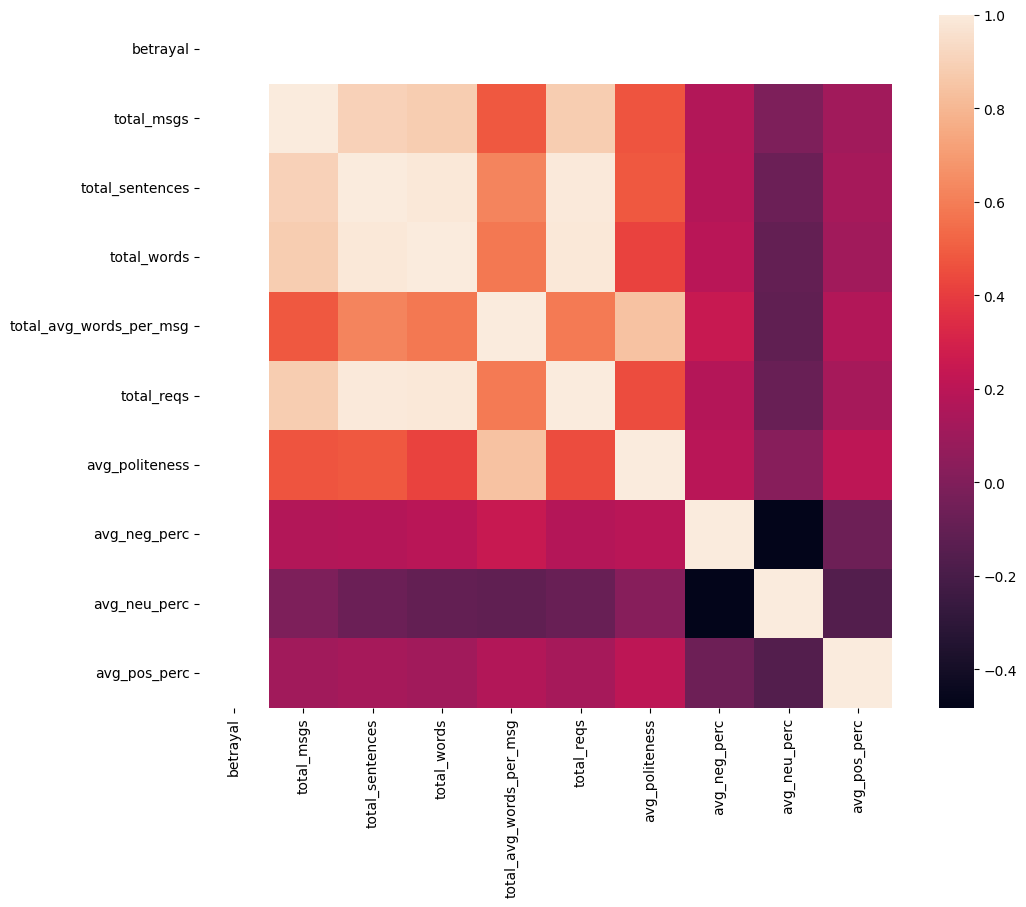

In [546]:
#correlation matrix
corrmat = new_false_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
z = sns.heatmap(corrmat, vmax=1, square=True);
plt.show(z);

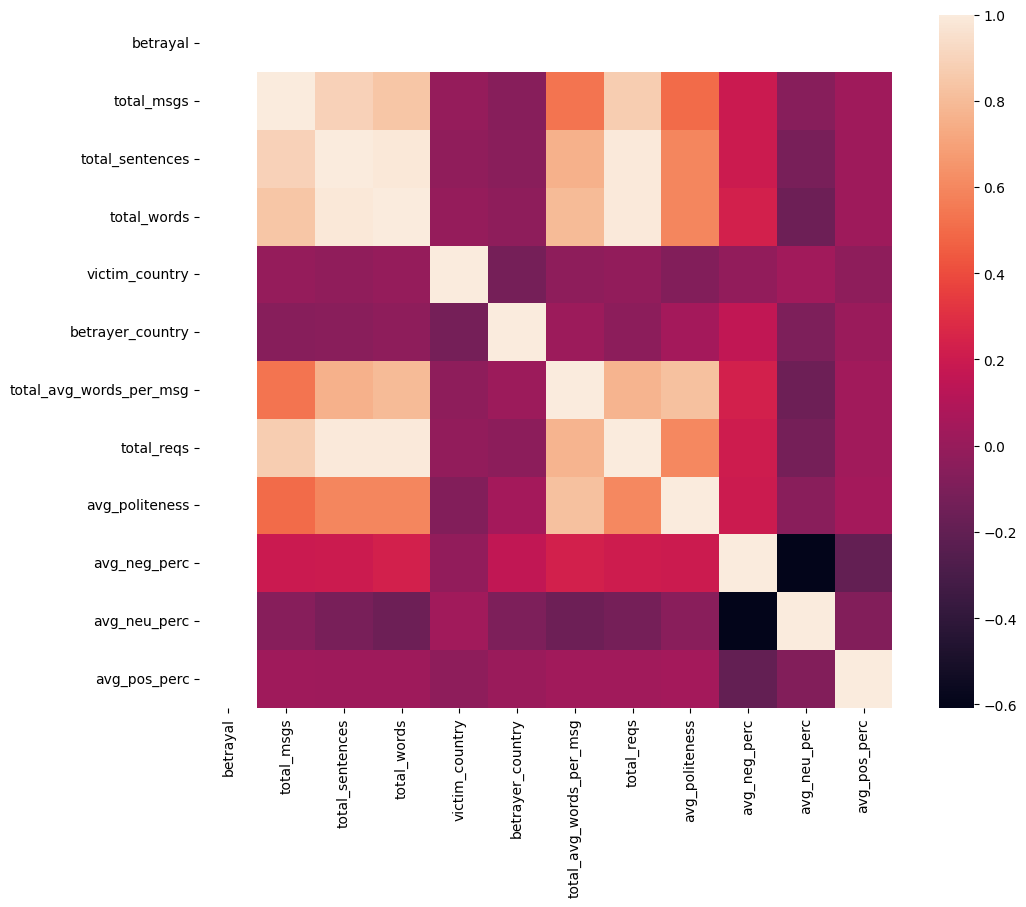

In [547]:
#correlation matrix
corrmat = new_true_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
z = sns.heatmap(corrmat, vmax=1, square=True);
plt.show(z);

<h2> Heatmap </h2>

In [548]:
drop_df.style.background_gradient(cmap='Blues')

,betrayal,victim_msgs,betrayer_msgs,victim_sentences,betrayer_sentences,victim_words,betrayer_words,victim_words_per_msg,betrayer_words_per_msg,victim_reqs,betrayer_reqs,victim_avg_polite,betrayer_avg_polite,victim_neg_perc,victim_neu_perc,victim_pos_perc,betrayer_neg_perc,betrayer_neu_perc,betrayer_pos_perc,victim_country,betrayer_country
0,True,2,30,112,108,1451,2104,725.500000,70.133333,39,83,6.700666,0.730269,0.544643,0.276786,0.178571,0.472222,0.296296,0.231481,0.000000,1.000000
5,True,1,20,108,121,1489,1697,1489.000000,84.850000,53,46,10.965025,0.683075,0.462963,0.333333,0.203704,0.446281,0.272727,0.280992,0.000000,0.500000
8,True,1,9,8,25,47,236,47.000000,26.222222,3,12,2.057574,0.586314,0.125000,0.500000,0.375000,0.400000,0.360000,0.240000,0.500000,1.000000
9,True,1,4,11,12,133,121,133.000000,30.250000,10,5,3.315499,0.598440,0.272727,0.727273,0.000000,0.500000,0.250000,0.250000,0.833333,0.000000
10,True,2,5,26,17,286,209,143.000000,41.800000,8,10,1.441538,0.564996,0.423077,0.423077,0.153846,0.529412,0.352941,0.117647,0.833333,0.666667
13,True,1,2,71,4,1427,57,1427.000000,28.500000,35,2,4.164357,0.691985,0.647887,0.169014,0.183099,0.500000,0.000000,0.500000,0.500000,0.833333
16,True,1,2,10,5,135,50,135.000000,25.000000,5,2,2.269605,0.657743,0.400000,0.500000,0.100000,0.400000,0.400000,0.200000,0.000000,0.333333
17,True,1,18,31,102,440,994,440.000000,55.222222,17,57,9.449386,0.752240,0.580645,0.290323,0.129032,0.333333,0.470588,0.196078,0.833333,1.000000
18,True,1,10,26,70,402,1280,402.000000,128.000000,16,39,4.249644,0.799682,0.576923,0.269231,0.153846,0.600000,0.242857,0.157143,1.000000,0.833333
20,True,2,9,94,96,1297,1221,648.500000,135.666667,57,34,2.515089,0.775977,0.500000,0.276596,0.223404,0.489583,0.312500,0.197917,0.000000,1.000000


<h2> Correlation </h2>

Let us get the correlation between features in the dataset.

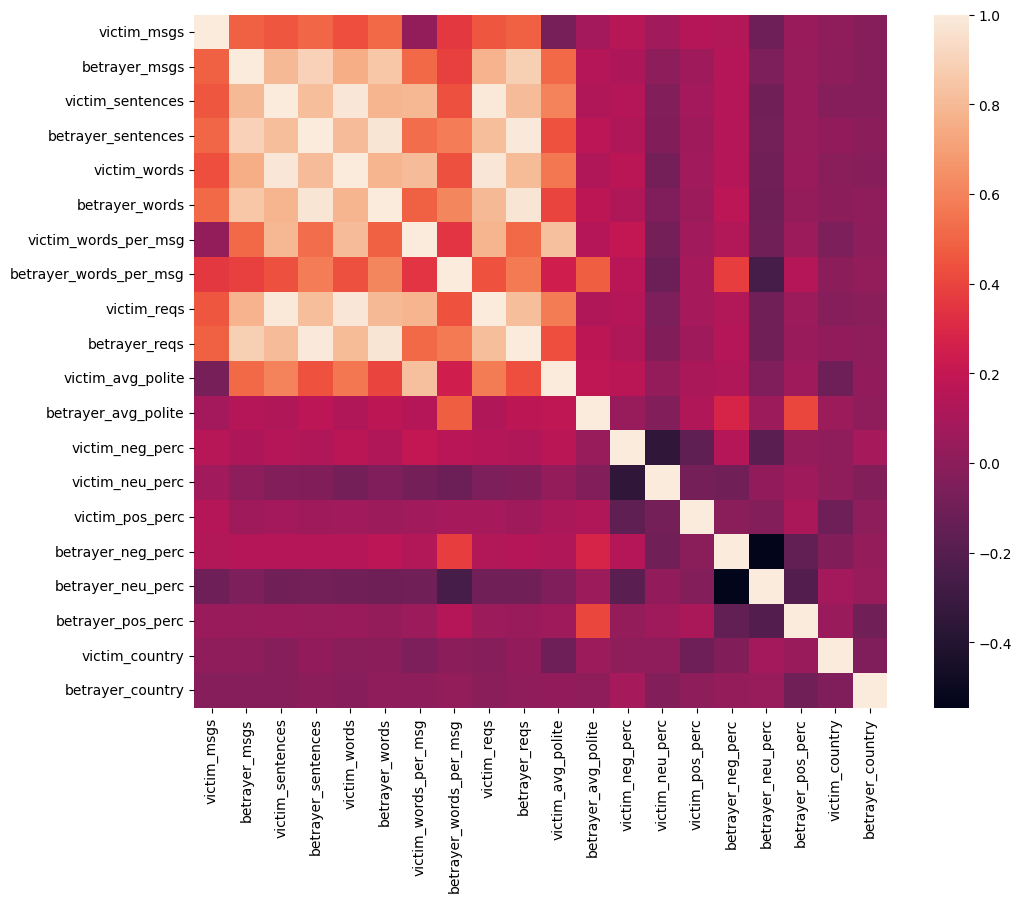

In [549]:
#correlation matrix
corrmat = X.corr()
f, ax = plt.subplots(figsize=(12, 9))
z = sns.heatmap(corrmat, vmax=1, square=True);
plt.show(z);

Messages, sentences and words are very correlated to one another. This makes sense, if you have more messages you have more words, and then you have more sentences. Nothing else stands out too much though.

Lets attempt to gather feature relevancy through P-scores.

In [550]:
from scipy.stats import chi2_contingency

print("Index P-values: ")
for index in X.keys():
    tmp = pd.crosstab(X[index], y)
    result = chi2_contingency(tmp)
    
    print("Index " + index + " P-Value: " + str(result[1]))

Index P-values: 
Index victim_msgs P-Value: 0.3927483908658845
Index betrayer_msgs P-Value: 0.6421009894287186
Index victim_sentences P-Value: 0.3029083228395732
Index betrayer_sentences P-Value: 0.41308010599671946
Index victim_words P-Value: 0.5016998876152111
Index betrayer_words P-Value: 0.3397315353108869
Index victim_words_per_msg P-Value: 0.5769650354253865
Index betrayer_words_per_msg P-Value: 0.43061250545625235
Index victim_reqs P-Value: 0.4014805234341584
Index betrayer_reqs P-Value: 0.2136857040874243
Index victim_avg_polite P-Value: 0.4778638917916376
Index betrayer_avg_polite P-Value: 0.4849632593134492
Index victim_neg_perc P-Value: 0.23726635942949453
Index victim_neu_perc P-Value: 0.41566404174739324
Index victim_pos_perc P-Value: 0.4113470440499891
Index betrayer_neg_perc P-Value: 0.3043985029830363
Index betrayer_neu_perc P-Value: 0.23823929243444433
Index betrayer_pos_perc P-Value: 0.36343139335899627
Index victim_country P-Value: 1.6316558134404522e-16
Index betray

Seemingly very little correlation between any of the features and the target, betrayal, except for the country of origin. This P-value is statistically relevant. For the other features, we can get some very poor certainty, around 60-80%, but let's try with some different methods and see how that describes the feature space.

In [551]:
for col in X:
    print(col + "'s pearson correlation to betrayal: " + str(X[col].corr(y)))

victim_msgs's pearson correlation to betrayal: 0.06324801592205415
betrayer_msgs's pearson correlation to betrayal: 0.031113915033441082
victim_sentences's pearson correlation to betrayal: 0.03120329466774843
betrayer_sentences's pearson correlation to betrayal: 0.03845140897262839
victim_words's pearson correlation to betrayal: 0.03116150590011901
betrayer_words's pearson correlation to betrayal: 0.016530331618914124
victim_words_per_msg's pearson correlation to betrayal: 0.0205075868710484
betrayer_words_per_msg's pearson correlation to betrayal: 0.04275755107362088
victim_reqs's pearson correlation to betrayal: 0.018190479087876434
betrayer_reqs's pearson correlation to betrayal: 0.03270925229787128
victim_avg_polite's pearson correlation to betrayal: -0.021274164162043564
betrayer_avg_polite's pearson correlation to betrayal: 0.06665495344709092
victim_neg_perc's pearson correlation to betrayal: -0.033449041655793176
victim_neu_perc's pearson correlation to betrayal: 0.056817984039

Again, very little correlation between any of the features and the target, betrayal, except again for victim and betrayer country. Still, only weak correlation.

Let's try with some different correlation methods.

In [552]:
for col in X:
    print(col + "'s spearman correlation to betrayal: " + str(X[col].corr(y, method='spearman')))

victim_msgs's spearman correlation to betrayal: 0.09130644110080842
betrayer_msgs's spearman correlation to betrayal: 0.07422727330388479
victim_sentences's spearman correlation to betrayal: 0.01976501597956776
betrayer_sentences's spearman correlation to betrayal: 0.10265527783679783
victim_words's spearman correlation to betrayal: 0.012097251649378018
betrayer_words's spearman correlation to betrayal: 0.08220490898222467
victim_words_per_msg's spearman correlation to betrayal: -0.02899631730384857
betrayer_words_per_msg's spearman correlation to betrayal: 0.06740845219459456
victim_reqs's spearman correlation to betrayal: 0.010101526478708952
betrayer_reqs's spearman correlation to betrayal: 0.10521212277260068
victim_avg_polite's spearman correlation to betrayal: -0.03884713921288399
betrayer_avg_polite's spearman correlation to betrayal: 0.07554834385948422
victim_neg_perc's spearman correlation to betrayal: -0.061298050425473476
victim_neu_perc's spearman correlation to betrayal: 

In [553]:
for col in X:
    print(col + "'s kendall correlation to betrayal: " + str(X[col].corr(y, method='kendall')))

victim_msgs's kendall correlation to betrayal: 0.08470119547125432
betrayer_msgs's kendall correlation to betrayal: 0.06194782379874699
victim_sentences's kendall correlation to betrayal: 0.016233732981342917
betrayer_sentences's kendall correlation to betrayal: 0.08427005654005895
victim_words's kendall correlation to betrayal: 0.009900661731440023
betrayer_words's kendall correlation to betrayal: 0.0672416701524242
victim_words_per_msg's kendall correlation to betrayal: -0.02373165394676809
betrayer_words_per_msg's kendall correlation to betrayal: 0.05513686069066876
victim_reqs's kendall correlation to betrayal: 0.00833733645894388
betrayer_reqs's kendall correlation to betrayal: 0.08675158909196715
victim_avg_polite's kendall correlation to betrayal: -0.031784888146538
betrayer_avg_polite's kendall correlation to betrayal: 0.061776280668027705
victim_neg_perc's kendall correlation to betrayal: -0.050307463269054546
victim_neu_perc's kendall correlation to betrayal: 0.05654736297989

Still, not very much to go off of, other than the country of origin. It realistically seems that many of the features collected in the dataset do not correlate very well to betrayal. However, I would not say that is the fault of the dataset, but moreso the premise of the problem. There are many issues with calculating and predicting deception or lying. 

According to the American Psychological Association (<a href="https://www.apa.org/topics/cognitive-neuroscience/polygraph#:~:text=The%20accuracy%20(i.e.%2C%20validity),person%20may%20be%20non%2Danxious">Truth about Lie Detectors</a>), there is very little evidence that even polygraph tests can detect lies. Obviously there are some general trends, for example, a liar might speak too much or speak too little. Liars may use particular words, or they may avoid certain words. But this is on a case by case basis, and these generalities are too vague and too loose to actually be applied in a real world scenario. Imagine being convicted of a crime, because a machine learning model predicted that you were. This goes heavily into the ethics of these applications, which I hope our project can demonstrate. Predicting lying can have devastating consequences.

# Preprocessing for betrayal detection

In [554]:
betrayal_df = X.copy()
betrayal = y.copy()

# to account for interactions of different lengths (with regards to msgs, sentences, words etc.)
# we will instead normalize it by converting it to proportions i.e. how much the victim talks in 
# comparison to the betrayer. Otherwise, the differing lengths of conversation may introduce a bias. 
# Note that differing convo lengths are still appropriate when attempting to predict betrayal 
# interactions as it takes aspects of the conversation as a whole
total_msgs = betrayal_df['victim_msgs'] + betrayal_df['betrayer_msgs']
total_sentences = betrayal_df['victim_sentences'] + betrayal_df['betrayer_sentences']
total_words = betrayal_df['victim_words'] + betrayal_df['betrayer_words']
total_reqs = betrayal_df['victim_reqs'] + betrayal_df['betrayer_reqs']

betrayal_df['victim_msgs_perc'] = betrayal_df['victim_msgs']/total_msgs
betrayal_df['betrayer_msgs_perc'] = betrayal_df['betrayer_msgs']/total_msgs
betrayal_df['victim_sens_perc'] = betrayal_df['victim_sentences']/total_sentences
betrayal_df['betrayer_sens_perc'] = betrayal_df['betrayer_sentences']/total_sentences
betrayal_df['victim_words_perc'] = betrayal_df['victim_words']/total_words
betrayal_df['betrayer_words_perc'] = betrayal_df['betrayer_words']/total_words
betrayal_df['victim_req_perc'] = betrayal_df['victim_reqs']/total_reqs
betrayal_df['betrayer_req_perc'] = betrayal_df['betrayer_reqs']/total_reqs

betrayal_df.drop(['betrayer_msgs', 'betrayer_sentences', 'betrayer_words', 'betrayer_reqs',
                       'victim_msgs', 'betrayer_msgs', 'victim_sentences', 'betrayer_sentences', 'victim_words', 'betrayer_words',
                 'victim_reqs', 'betrayer_reqs'],
                       axis=1, inplace=True)

# now we have to bin these floating point values for it to work with our DecisionTrees
bins = 4 # does not need to be so granular for some ratio of message lengths
attributes = betrayal_df.columns.values.tolist()

print(attributes)

bin4 = {'victim_msgs_perc', 'victim_sens_perc', 'victim_words_perc', 'victim_req_perc',
        'betrayer_msgs_perc', 'betrayer_sens_perc', 'betrayer_words_perc', 'betrayer_req_perc'}
bin5 = {'victim_words_per_msg_perc', 'victim_avg_polite_perc','victim_neg_perc_perc', 'victim_neu_perc_perc', 'victim_pos_perc_perc',
       'betrayer_words_per_msg_perc', 'betrayer_avg_polite_perc','betrayer_neg_perc_perc', 'betrayer_neu_perc_perc', 'betrayer_pos_perc_perc'}

for attribute in attributes:
    if attribute in bin4 : bin = 4
    if attribute in bin5 : bin = 5
    if attribute == 'country_perc': bin = num_of_countries
    if re.match('_perc$', attribute):
        betrayal_df[re.sub('_perc$', '_bin', attribute)] = pd.cut(betrayal_df[attribute], bins).cat.codes
    else:
        betrayal_df[attribute+'_perc'] = pd.cut(betrayal_df[attribute], bins).cat.codes
    betrayal_df.drop([attribute], axis=1, inplace=True)


# betrayer_identify.drop(['victim_msgs_perc', 'victim_sentences_perc', 'victim_words_perc', 'victim_reqs_perc',
#                        'victim_words_per_msg', 'victim_avg_polite', 'victim_neg_perc', 'victim_neu_perc', 'victim_pos_perc', 'victim_country_perc', 
#                         'betrayer_msgs_perc', 'betrayer_sentences_perc', 'betrayer_words_perc', 'betrayer_reqs_perc',
#                        'betrayer_words_per_msg', 'betrayer_avg_polite', 'betrayer_neg_perc', 'betrayer_neu_perc', 'betrayer_pos_perc', 'betrayer_country_perc'],
#                        axis=1, inplace=True)


#display(betrayal_identify)

['victim_words_per_msg', 'betrayer_words_per_msg', 'victim_avg_polite', 'betrayer_avg_polite', 'victim_neg_perc', 'victim_neu_perc', 'victim_pos_perc', 'betrayer_neg_perc', 'betrayer_neu_perc', 'betrayer_pos_perc', 'victim_country', 'betrayer_country', 'victim_msgs_perc', 'betrayer_msgs_perc', 'victim_sens_perc', 'betrayer_sens_perc', 'victim_words_perc', 'betrayer_words_perc', 'victim_req_perc', 'betrayer_req_perc']


# Preprocessing for betrayer identification

We will also be training an additional model to determine the characteristics of a betrayer. In other words, we will take all interactions between a betrayer and a victim, and will see if we can use our data regarding messaging behavior to predict whether or not someone is the betrayer. Here we need to further process our previously processed dataframe as below.

In [555]:
b_df = new_df.drop(new_df[new_df.betrayal == False].index)
# retain only betrayal interactions

b_df.reset_index(drop=True, inplace=True)

# to account for interactions of different lengths (with regards to msgs, sentences, words etc.)
# we will instead normalize it by converting it to proportions i.e. how much the victim talks in 
# comparison to the betrayer. Otherwise, the differing lengths of conversation may introduce a bias. 
# Note that differing convo lengths are still appropriate when attempting to predict betrayal 
# interactions as it takes aspects of the conversation as a whole
total_msgs = b_df['victim_msgs'] + b_df['betrayer_msgs']
total_sentences = b_df['victim_sentences'] + b_df['betrayer_sentences']
total_words = b_df['victim_words'] + b_df['betrayer_words']
total_reqs = b_df['victim_reqs'] + b_df['betrayer_reqs']

b_df['victim_msgs_perc'] = b_df['victim_msgs']/total_msgs
b_df['betrayer_msgs_perc'] = b_df['betrayer_msgs']/total_msgs
b_df['victim_sens_perc'] = b_df['victim_sentences']/total_sentences
b_df['betrayer_sens_perc'] = b_df['betrayer_sentences']/total_sentences
b_df['victim_words_perc'] = b_df['victim_words']/total_words
b_df['betrayer_words_perc'] = b_df['betrayer_words']/total_words
b_df['victim_req_perc'] = b_df['victim_reqs']/total_reqs
b_df['betrayer_req_perc'] = b_df['betrayer_reqs']/total_reqs

# let's now split this dataset into two datasets, one with only victim data, the 
# other with only betrayer data

victim_df = b_df[['victim_msgs_perc', 'victim_sens_perc', 'victim_words_perc', 'victim_words_per_msg', 
                 'victim_req_perc', 'victim_avg_polite', 'victim_neg_perc', 'victim_neu_perc',
                 'victim_pos_perc']].copy()

betrayer_df = b_df[['betrayer_msgs_perc', 'betrayer_sens_perc', 'betrayer_words_perc', 'betrayer_words_per_msg',
                   'betrayer_req_perc', 'betrayer_avg_polite', 'betrayer_neg_perc',  'betrayer_neu_perc',
                    'betrayer_pos_perc']].copy()

# then we can add a new column that denotes if this is the betrayer or the victim
victim_df['betrayer'] = False
betrayer_df['betrayer'] = True

# rename columns to match
rename_vic = {'victim_msgs_perc': 'msgs_perc', 'victim_sens_perc': 'sentences_perc', 'victim_words_perc': 'words_perc', 
              'victim_words_per_msg': 'words_per_msg', 'victim_req_perc': 'reqs_perc', 
              'victim_avg_polite': 'avg_polite', 'victim_neg_perc': 'neg_perc', 
              'victim_neu_perc': 'neu_perc', 'victim_pos_perc': 'pos_perc'}

rename_bet = {'betrayer_msgs_perc': 'msgs_perc', 'betrayer_sens_perc': 'sentences_perc', 'betrayer_words_perc': 'words_perc', 
              'betrayer_words_per_msg': 'words_per_msg', 'betrayer_req_perc': 'reqs_perc', 
              'betrayer_avg_polite': 'avg_polite', 'betrayer_neg_perc': 'neg_perc', 
              'betrayer_neu_perc': 'neu_perc', 'betrayer_pos_perc': 'pos_perc'}

victim_df = victim_df.rename(columns=rename_vic)
betrayer_df = betrayer_df.rename(columns=rename_bet)

betrayer_identify = pd.concat([victim_df, betrayer_df], ignore_index=True)

# display(betrayer_identify)

#print(betrayer_identify.columns.values.tolist())

# now we have to bin these floating point values for it to work with our DecisionTrees
bins = 4 # does not need to be so granular for some ratio of message lengths
attributes = betrayer_identify.columns.values.tolist()
attributes.remove("betrayer")


bin4 = {'msgs_perc', 'sens_perc', 'words_perc', 'req_perc'}
bin5 = {'words_per_msg_perc', 'avg_polite_perc','neg_perc_perc', 'neu_perc_perc', 'pos_perc_perc'}

for attribute in attributes:
    if attribute in bin4 : bin = 4
    if attribute in bin5 : bin = 5
    betrayer_identify[re.sub('_perc$', '_bin', attribute)] = pd.cut(betrayer_identify[attribute], bins).cat.codes



betrayer_identify.drop(['msgs_perc', 'sentences_perc', 'words_perc', 'reqs_perc',
                       'words_per_msg', 'avg_polite', 'neg_perc', 'neu_perc', 'pos_perc'],
                       axis=1, inplace=True)

#display(betrayer_identify)

# Training of decision trees (Betrayal)

In [556]:
# now with this new dataframe, let's see if we can identify betrayers!
input_features = betrayal_df
target = betrayal

X_train, X_test, Y_train, Y_test = train_test_split(input_features, target, test_size = 0.2, random_state = 5)

# Prepare the parameter grid for max_depth
param_grid = {'max_depth': range(1, 11)}
crossValidation = 10

# Gini Decision Tree with GridSearchCV
gini_tree = DecisionTreeClassifier(criterion='gini', random_state=30)
grid_gini_tree = GridSearchCV(gini_tree, param_grid, cv=crossValidation)
grid_gini_tree.fit(X_train, Y_train)
best_gini_depth = grid_gini_tree.best_params_['max_depth']

# Evaluate
accuracy = grid_gini_tree.score(X_test, Y_test) * 100
print(f"Accuracy of gini tree with max_depth {best_gini_depth}: {accuracy} %")

# Entropy Decision Tree with GridSearchCV
entropy_tree = DecisionTreeClassifier(criterion='entropy', random_state=30)
grid_entropy_tree = GridSearchCV(entropy_tree, param_grid, cv=crossValidation)
grid_entropy_tree.fit(X_train, Y_train)
best_entropy_depth = grid_entropy_tree.best_params_['max_depth']

# Evaluate
accuracy = grid_entropy_tree.score(X_test, Y_test) * 100
print(f"Accuracy of entropy tree with max_depth {best_entropy_depth}: {accuracy} %")

# Random Forest with GridSearchCV
param_grid_rf = {'max_depth': range(1, 11), 'n_estimators': range(10, 21)}
random_forest = RandomForestClassifier(random_state=100)
grid_random_forest = GridSearchCV(random_forest, param_grid_rf, cv=crossValidation)
grid_random_forest.fit(X_train, Y_train)
best_rf_depth = grid_random_forest.best_params_['max_depth']
best_rf_n_estimators = grid_random_forest.best_params_['n_estimators']

# Evaluate
accuracy = grid_random_forest.score(X_test, Y_test) * 100
print(f"Accuracy of random forest with max_depth {best_rf_depth} and n_estimators {best_rf_n_estimators}: {accuracy} %")


Accuracy of gini tree with max_depth 3: 75.60975609756098 %
Accuracy of entropy tree with max_depth 3: 75.60975609756098 %
Accuracy of random forest with max_depth 4 and n_estimators 20: 69.51219512195121 %


# Performance comparison

In [557]:
# perform 10-fold cross validation
gini_score = cross_val_score(gini_tree, X_train, Y_train, cv=10)
entropy_score = cross_val_score(entropy_tree, X_train, Y_train, cv=10)
random_forest_score = cross_val_score(random_forest, X_train, Y_train, cv=10)

# output the mean of these scores
print("Gini mean score: {}".format(np.mean(gini_score)))
print("Entropy mean score: {}".format(np.mean(entropy_score)))
print("Random forest mean score: {}".format(np.mean(random_forest_score)))

Gini mean score: 0.6215909090909092
Entropy mean score: 0.6608901515151515
Random forest mean score: 0.6581439393939394


# Training of decision trees (Betrayer)

In [560]:
# now with this new dataframe, let's see if we can identify betrayers!
input_features = betrayer_identify.drop(columns=["betrayer"],axis=1)
target = betrayer_identify["betrayer"] # target

X_train, X_test, Y_train, Y_test = train_test_split(input_features, target, test_size = 0.2, random_state = 5)

# Prepare the parameter grid for max_depth
param_grid = {'max_depth': range(1, 11)}
crossValidation = 10

# Gini Decision Tree with GridSearchCV
gini_tree = DecisionTreeClassifier(criterion='gini', random_state=30)
grid_gini_tree = GridSearchCV(gini_tree, param_grid, cv=crossValidation)
grid_gini_tree.fit(X_train, Y_train)
best_gini_depth = grid_gini_tree.best_params_['max_depth']

# Evaluate
accuracy = grid_gini_tree.score(X_test, Y_test) * 100
print(f"Accuracy of gini tree with max_depth {best_gini_depth}: {accuracy} %")

# Entropy Decision Tree with GridSearchCV
entropy_tree = DecisionTreeClassifier(criterion='entropy', random_state=30)
grid_entropy_tree = GridSearchCV(entropy_tree, param_grid, cv=crossValidation)
grid_entropy_tree.fit(X_train, Y_train)
best_entropy_depth = grid_entropy_tree.best_params_['max_depth']

# Evaluate
accuracy = grid_entropy_tree.score(X_test, Y_test) * 100
print(f"Accuracy of entropy tree with max_depth {best_entropy_depth}: {accuracy} %")

# Random Forest with GridSearchCV
param_grid_rf = {'max_depth': range(1, 11), 'n_estimators': range(10, 21)}
random_forest = RandomForestClassifier(random_state=100)
grid_random_forest = GridSearchCV(random_forest, param_grid_rf, cv=crossValidation)
grid_random_forest.fit(X_train, Y_train)
best_rf_depth = grid_random_forest.best_params_['max_depth']
best_rf_n_estimators = grid_random_forest.best_params_['n_estimators']

# Evaluate
accuracy = grid_random_forest.score(X_test, Y_test) * 100
print(f"Accuracy of random forest with max_depth {best_rf_depth} and n_estimators {best_rf_n_estimators}: {accuracy} %")


['betrayer', 'msgs_bin', 'sentences_bin', 'words_bin', 'reqs_bin', 'neg_bin', 'neu_bin', 'pos_bin']
Accuracy of gini tree with max_depth 4: 90.2439024390244 %
Accuracy of entropy tree with max_depth 4: 93.90243902439023 %
Accuracy of random forest with max_depth 5 and n_estimators 13: 92.6829268292683 %


# Performance comparison

In [559]:
# perform 10-fold cross validation
gini_score = cross_val_score(gini_tree, X_train, Y_train, cv=10)
entropy_score = cross_val_score(entropy_tree, X_train, Y_train, cv=10)
random_forest_score = cross_val_score(random_forest, X_train, Y_train, cv=10)

# output the mean of these scores
print("Gini mean score: {}".format(np.mean(gini_score)))
print("Entropy mean score: {}".format(np.mean(entropy_score)))
print("Random forest mean score: {}".format(np.mean(random_forest_score)))

Gini mean score: 0.9294507575757576
Entropy mean score: 0.9294507575757576
Random forest mean score: 0.9477272727272726
